In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_221007'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [96]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and958_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


# Set the qubits/resonators to probe

In [190]:
qubits = [2, 1] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [97]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [98]:
im = InstrumentManager(ns_address='192.168.14.1')

In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [99]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [144]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 10
npts = 101

qZZspec.cfg.expt = dict(
    # start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2, # resonator frequency to be mixed up [MHz]
    start=3458.5-span/2,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=5, # qubit 0 probe constant pulse length [us]
    gain=1000, # qubit 0 const pulse gain
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 108, 62, 70], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3458.5643364520165, 0, 3462.6448268980225, 3462.4591431610106], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2685.75, 0, 2024.35, 2409.45], 'gs': [56.41030563, 74.31933724, 50.37948286, 19.70297012, 5.79175295, 10.44168119], 'ZZs': [0.0, -5.611248883296696, -0.9077369989172155, -1.2532967772105224, -4.73985497354488, 0.0, -1.4022731445775207, -1.2870946887073842, -1.305047898765224, -2.171251188191718, 0.0, -1.670317069756834, -1.2216609320071825, -1.8378619821536404, -0.839652822565597, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 27054], 'sigma': [0.041, 0.018, 0.047, 0.022], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 24296], 'sigma': [0.036, 0.015, 0.018, 0.019], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21984, 0, 22637, 12454], 'sig

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3462.539229306772, HWHM 1.167756556823388
Found peak in I at [MHz] 3458.7738562982126, HWHM 1.952360530434897
Found peak in Q at [MHz] 3458.556574634454, HWHM 1.838315995899017


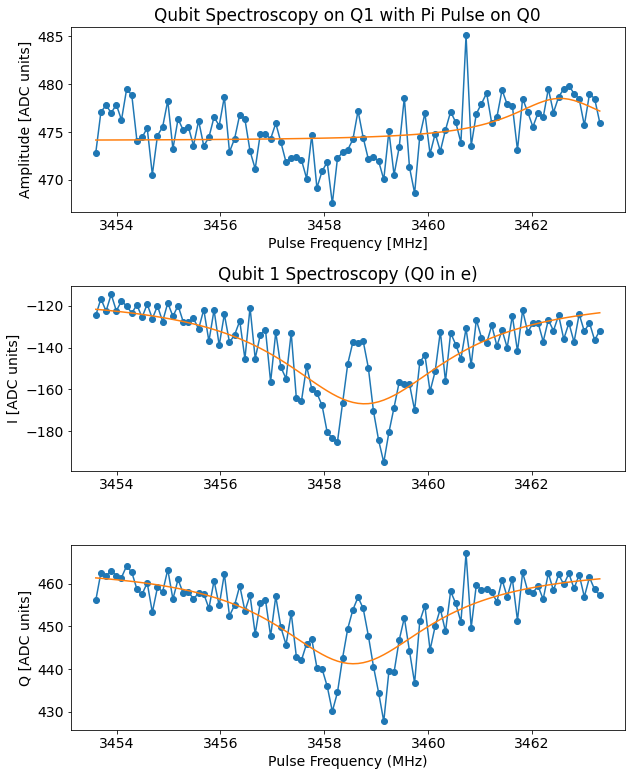

In [145]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [55]:
qZZspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_qubit_coupling_spectroscopy_qubit01.h5


# Length rabi for Q1 with QA in e

In [51]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [73, 128, 46, 58], 'f_ge': [826.6246419342525, 3470.204764189285, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [637.2764733473786, 3369.7243020025294, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.9, -1, 2681.7, 2384.37], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [23801, 21866, 22539, 28755], 'sigma': [0.0403, 0.0197, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [30000, 16999, 20765, 29402], 'sigma': [0.02, 0.015, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.018, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3000, 0, 2750, 3000], 'sigma': [0.396, 0, 0.232, 0.276], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [812.846, -807.358, -79.784, 81.67042225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.9, 0.27, 0.27, 0.85]

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 83.99916000000002, which is out of bounds 0.3535318181818182 to 53.02977272727273. Instead init to 26.691652272727275
Pi length from avgi data (qubit B) [us]: 0.021599656517148482
	Pi/2 length from avgi data (qubit B) [us]: 0.010799828258574241
Pi length from avgq data (qubit B) [us]: 0.021455783942806932
	Pi/2 length from avgq data (qubit B) [us]: 0.010727891971403466


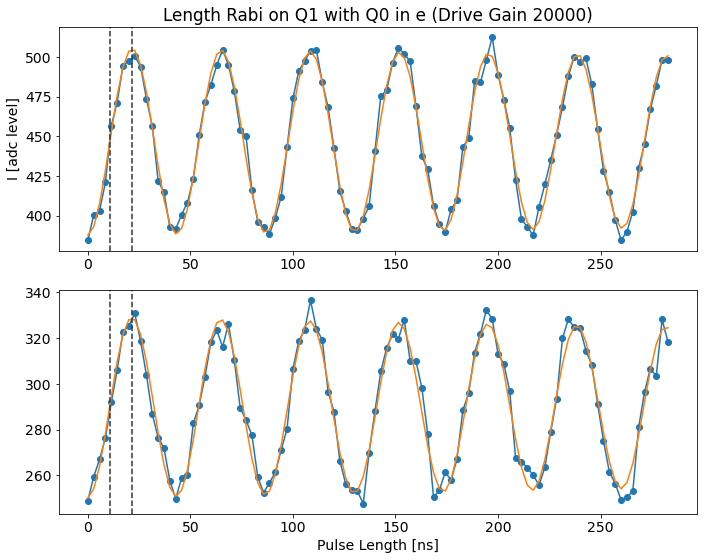

In [52]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [24]:
lengthrabiZZ.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_length_rabi_ZZ_qubit31.h5


# Pulse probe eg-gf spectroscopy

In [11]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)

# print(f_ge + f_ef - f_ge[1])
print(f_ge[1] + f_ef[1] - f_ge)

[2686.64474859 3363.37374353 2025.52648373 2411.72747829]


In [15]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [806.087775593827, 3464.4496477749913, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.6655790699174, 0, 3459.718643790527, 3463.5163174610875], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2022.6223138, 3364.26044161, 2683.13805444, 2403.14008939], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.0326, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [30000, 0, 15880, 30000], 'sigma': [0.022877223175459725, 0, 0.05739835717369027, 0.016160253718707353], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.436], 'lo_sideband'

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2011.0772790316635, HWHM 1.0630988234280279
Found peak in avgq data (qubit A) at [MHz] 2011.059302455054, HWHM 0.9029036822409753
Found peak in avgi data (qubit B) at [MHz] 2011.0325283890313, HWHM 0.9407213882735002
Found peak in avgq data (qubit B) at [MHz] 2011.0143256501299, HWHM 0.9636483374316271


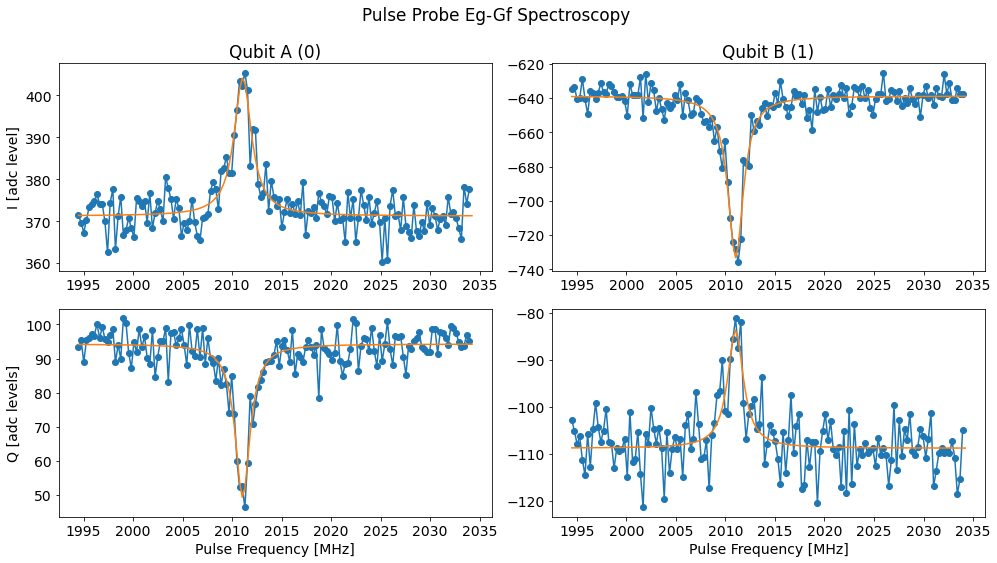

In [15]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [16]:
qEgGfspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_qubit_EgGf_spectroscopy_qubit01.h5


### Pulse probe EgGF power sweep

In [18]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

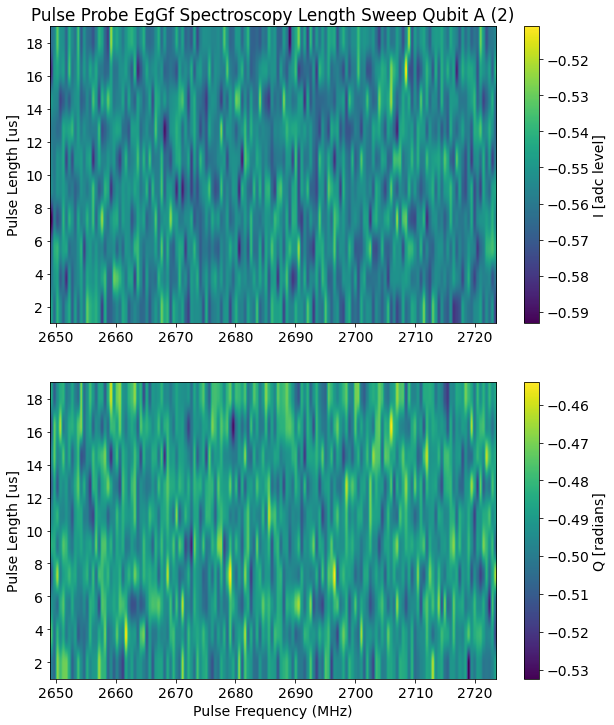

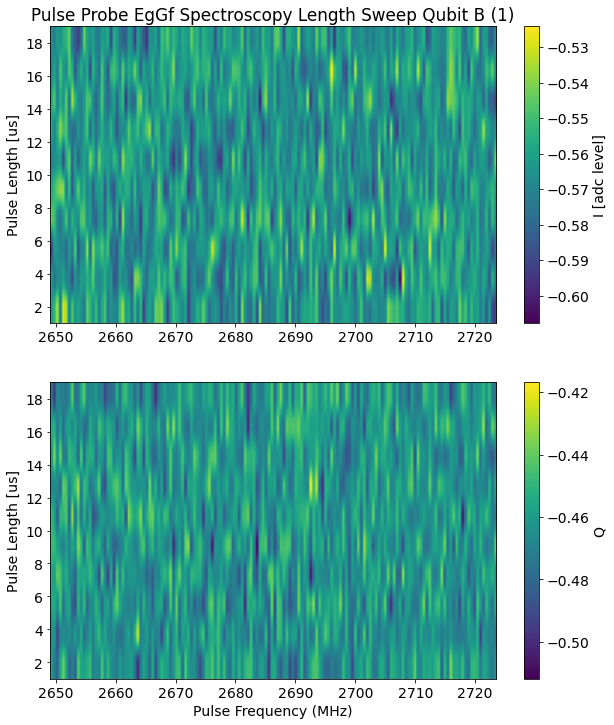

In [19]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

# Rabi eg-gf chevron (freq vs. amplitude)

In [128]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqgain_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 10000
npts_gain = 25
# span_gain = 0
# npts_gain = 40

span_f = 10 # MHz
npts_f = 25
# span_f = 0
# npts_f = 40

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=100, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    # start_f=2402,
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] + 6 - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    rounds=50,
    reps=10,
    pi_EgGf_sigma=0.700, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='flat_top',
    qubits=qubits,
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2019, 2408.2], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 21672, 23287, 22760], 'sigma': [0.03099, 0.01781, 0.01679, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21703, 0, 21713, 24537], 'sigma': [0.01776, 0, 0.

  0%|          | 0/25 [00:00<?, ?it/s]

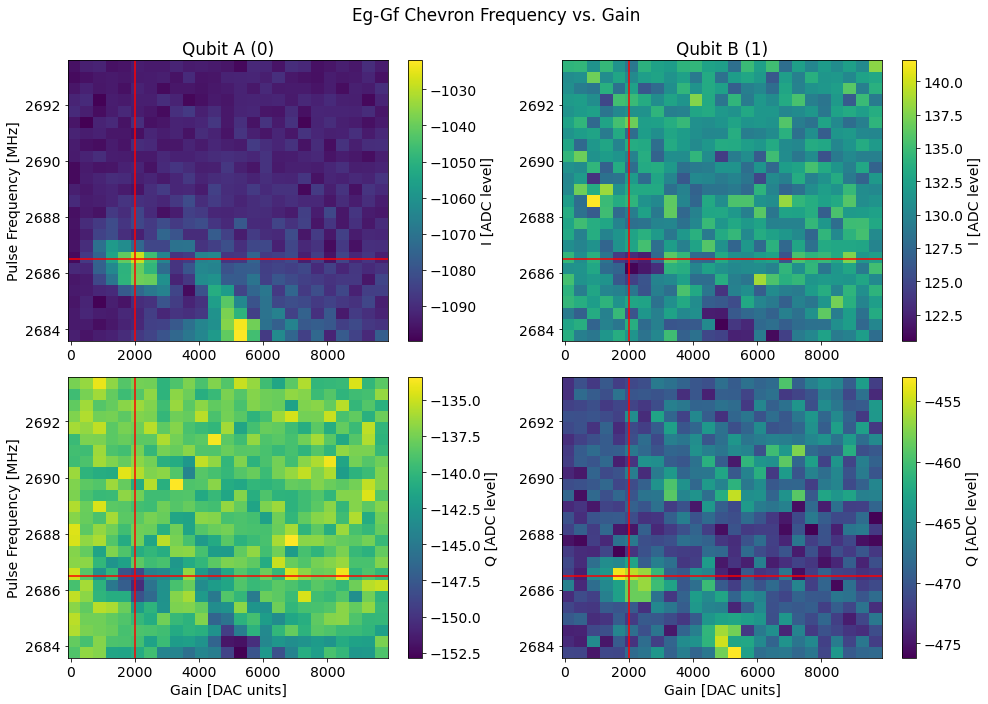

In [130]:
# # TESTING
# rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_rabi_EgGf_gainlen_chevron_qubit01.h5')
# rabiEgGfFreqGainChevron.cfg.expt = attrs['config']['expt']
# print(temp_data.keys())
# rabiEgGfFreqGainChevron.display(data=temp_data, saveplot=True) #, plot_freq=2024.5, plot_gain=2125)
# data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=data, fit=True)

rabiEgGfFreqGainChevron.analyze(data=None)
rabiEgGfFreqGainChevron.display(data=None, plot_freq=2686.5, plot_gain=2000)

In [38]:
rabiEgGfFreqGainChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00002_rabi_EgGf_freqgain_chevron_qubit31.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00002_rabi_EgGf_freqgain_chevron_qubit31.h5'

# Rabi eg-gf chevron (freq vs. len)

In [191]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 4 # MHz
npts_f = 15
    
rabiEgGfFreqLenChevron.cfg.expt = dict(
    # start_f=2686.5 - span_f/2, # start freq [MHz],
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    start_len=soc.cycles2us(12), # pulse length (sigma) [us]
    step_len=soc.cycles2us(7), # [us]
    expts_len=45,
    # gain=2000,
    reps=1000,
    pulse_type='flat_top',
    post_process='threshold',
    singleshot_reps=10000,
    measure_f=True,
    qubits=qubits,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

import Pyro4.util
try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2019, 2408.2], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 21672, 23287, 22760], 'sigma': [0.03099, 0.01781, 0.01679, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21703, 0, 21713, 24537], 'sigma': [0.01776, 0, 0.

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 16.242436365454818 	 angle (deg): 151.1140458377994 	 threshold ge: -50.789315600977915
Qubit  (1)
ge fidelity (%): 56.732836641832094 	 angle (deg): 95.53299793212291 	 threshold ge: -420.8272140301842


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 15.430771538576929 	 angle (deg): 148.74303755107994 	 threshold ge: -58.23911751430026
Qubit  (1)
ge fidelity (%): 60.30301515075753 	 angle (deg): 96.93179619843974 	 threshold ge: -416.07919834527104


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 15.37076853842692 	 angle (deg): 154.30104908036247 	 threshold ge: -57.71222164345414
Qubit  (1)
ge fidelity (%): 61.543077153857695 	 angle (deg): 97.35460997700815 	 threshold ge: -416.87022503933775


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 16.8108405420271 	 angle (deg): 150.62637318658997 	 threshold ge: -57.8663017626252
Qubit  (1)
ge fidelity (%): 57.70288514425721 	 angle (deg): 97.36917276013041 	 threshold ge: -420.2242930966519


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 15.780789039451973 	 angle (deg): 151.46817754732808 	 threshold ge: -69.41712715090148
Qubit  (1)
ge fidelity (%): 57.20286014300715 	 angle (deg): 98.9342660716728 	 threshold ge: -422.21123878031216


min qA 0.0
[[ 6 42]]
freq 2018.8666666666666 len 727.7715773809524
max qB 0.722
[[ 2 11]]
freq 2017.8 len 223.21428571428572


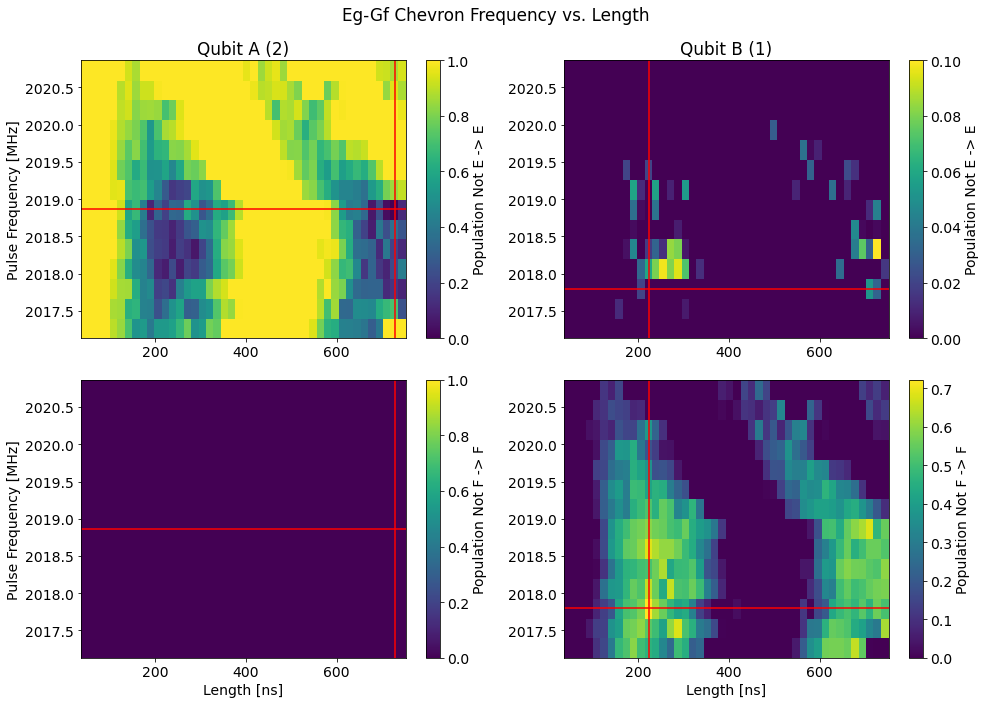

In [192]:
# TESTINGV
# rabiEgGfChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
# # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00001_rabi_EgGf_gainlen_chevron_qubit01.h5')
# rabiEgGfChevron.cfg.expt = attrs['config']['expt']
# print(temp_data.keys())
# # data = rabiEgGfChevron.analyze(data=temp_data, fit=True)
# rabiEgGfChevron.display(data=temp_data)
# rabiEgGfChevron.display(data=temp_data, saveplot=True)
rabiEgGfFreqLenChevron.analyze(data=None)
rabiEgGfFreqLenChevron.display(data=None) #, plot_freq=2410.9, plot_len=800)

In [189]:
rabiEgGfFreqLenChevron.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00002_rabi_EgGf_freqlen_chevron_qubit01.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00002_rabi_EgGf_freqlen_chevron_qubit01.h5'

# 3D sweep to optimize length, gain, freq

In [108]:
2027 - np.arange(expts_gain)*(10/8000*step_gain)

array([2027. , 2024.5, 2022. , 2019.5, 2017. ])

[ 2000  4000  6000  8000 10000]
Now setting gain to 2000
Freq sweep will be centered at [2412.         2408.66666667 2405.33333333 2402.         2398.66666667]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 19.13397113237108 	 angle (deg): 20.928346759082185 	 threshold ge: 785.1597382694313
Qubit  (1)
ge fidelity (%): 58.37527917597253 	 angle (deg): 145.77429784617593 	 threshold ge: -423.00743468212806
min qA 0.04276532685591793
[[ 7 28]]
freq 2411.1 len 804.5014880952382
max qB 0.9324635142981099
[[ 7 27]]
freq 2411.1 len 776.5997023809524


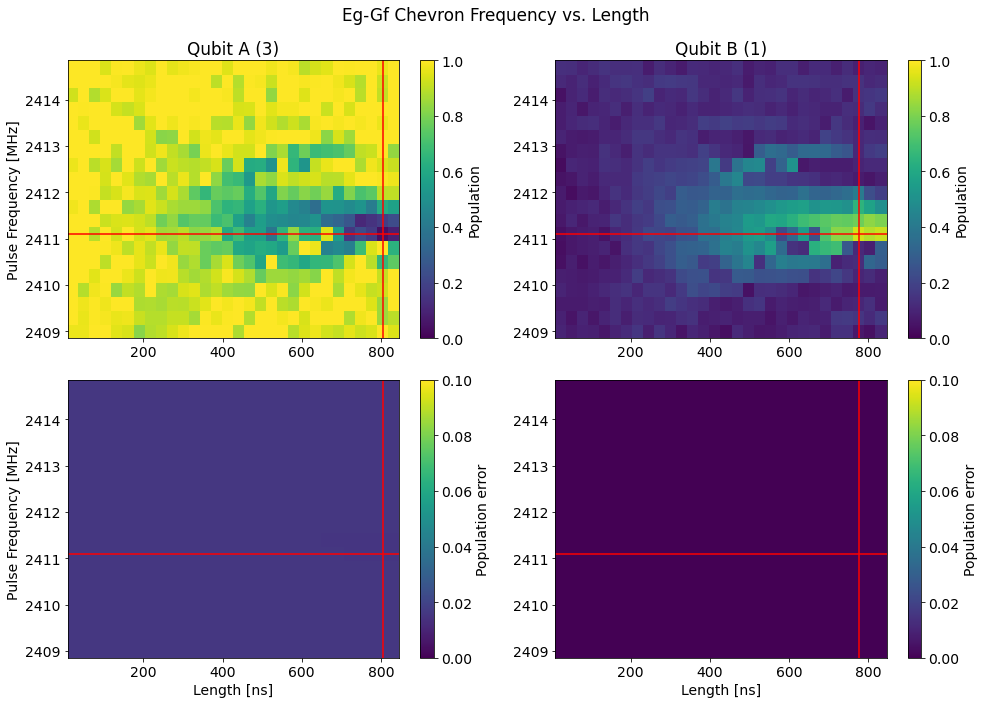

Now setting gain to 4000


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 20.014000466682223 	 angle (deg): 18.567148786088865 	 threshold ge: 778.4488924226844
Qubit  (1)
ge fidelity (%): 58.668622287409576 	 angle (deg): 145.37469459276784 	 threshold ge: -422.1551074066734
min qA -0.07309833396513285
[[12 17]]
freq 2409.2666666666664 len 497.58184523809524
max qB 1.0536104055842488
[[12 16]]
freq 2409.2666666666664 len 469.6800595238095


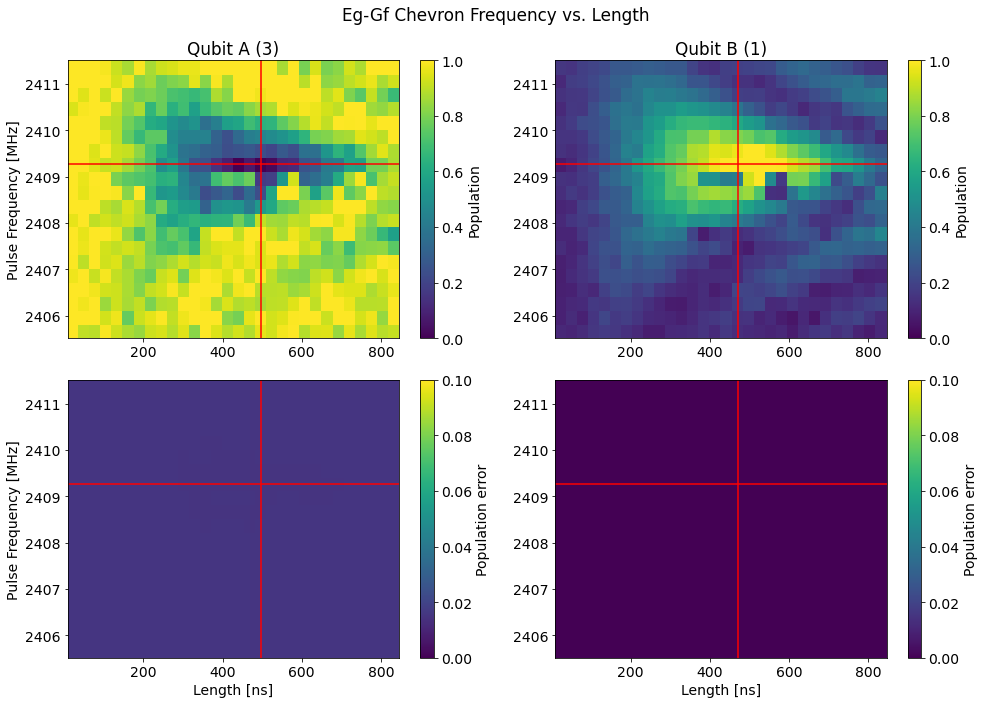

Now setting gain to 6000


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 19.820660688689625 	 angle (deg): 23.827568611386425 	 threshold ge: 783.194807212097
Qubit  (1)
ge fidelity (%): 57.59525317510583 	 angle (deg): 143.88339961946878 	 threshold ge: -414.23754607254284
min qA -0.00259988683345074
[[11 12]]
freq 2405.6333333333337 len 358.0729166666667
max qB 1.0587671390873128
[[11 11]]
freq 2405.6333333333337 len 330.1711309523809


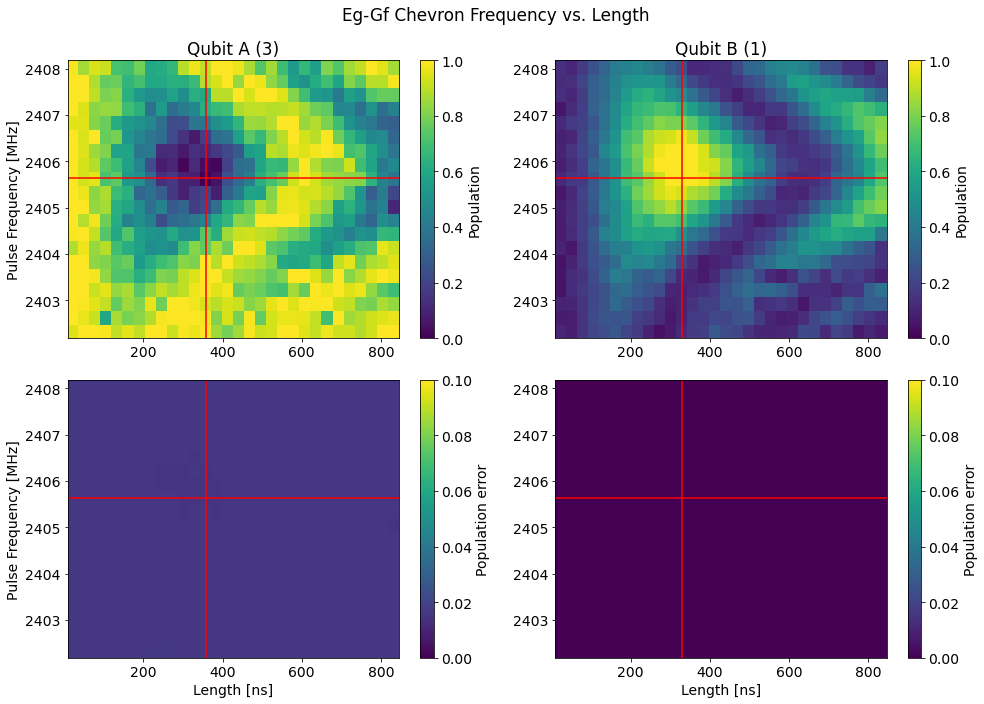

Now setting gain to 8000


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 20.014000466682223 	 angle (deg): 20.391318736222868 	 threshold ge: 784.7002301950076
Qubit  (1)
ge fidelity (%): 57.51525050835028 	 angle (deg): 143.55807424364033 	 threshold ge: -413.7227331341072
min qA -0.06033962061852535
[[5 9]]
freq 2400.5 len 274.3675595238095
max qB 1.08101297036065
[[6 8]]
freq 2400.8 len 246.46577380952382


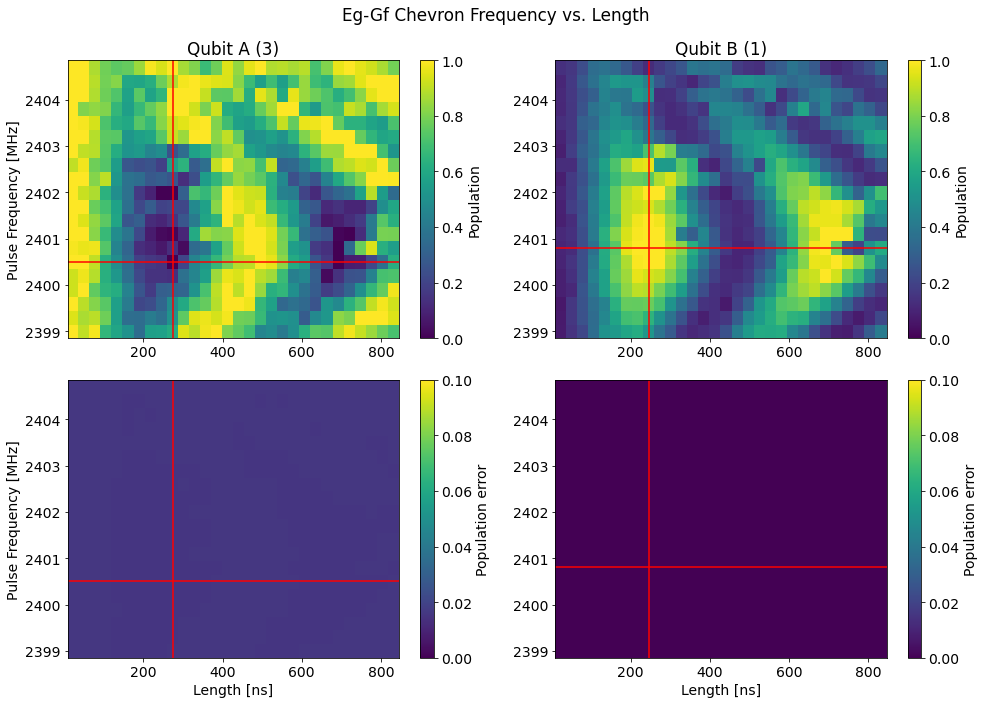

Now setting gain to 10000


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 20.055338867220055 	 angle (deg): 22.903311187900478 	 threshold ge: 787.480974406492
Qubit  (1)
ge fidelity (%): 56.71711447429829 	 angle (deg): 143.67774377144121 	 threshold ge: -406.5942970056689
min qA 0.06174515497161552
[[1 7]]
freq 2395.9666666666667 len 218.56398809523807
max qB 0.9888844605046945
[[1 7]]
freq 2395.9666666666667 len 218.56398809523807


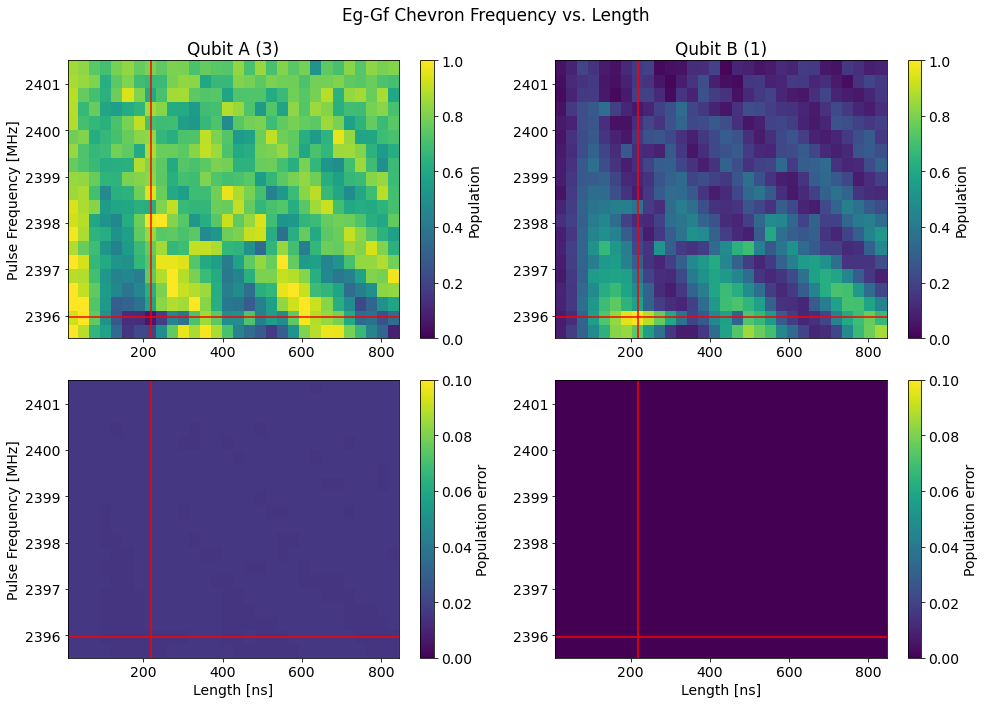

In [118]:
start_gain = 2000
step_gain = 2000
expts_gain = 5
gain_sweep = start_gain + step_gain * np.arange(expts_gain)
print(gain_sweep)

sweep2d_expt_progs = []

for ig, gain in enumerate(gain_sweep):
    print('Now setting gain to', gain)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 6 # MHz
    npts_f = 20

    freq_center_pts = 2412 - np.arange(expts_gain)*(10/6000*step_gain)
    if ig==0: print('Freq sweep will be centered at', freq_center_pts)

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq_center_pts[ig] - span_f/2,
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=soc.cycles2us(10), # pulse length (sigma) [us]
        step_len=soc.cycles2us(12), # [us]
        expts_len=30,
        gain=gain,
        reps=1000,
        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        qubits=qubits,
    )

    # rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
    # rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

    # print(rabiEgGfFreqLenChevron.cfg)

    import Pyro4.util
    try:
        rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    rabiEgGfFreqLenChevron.analyze(data=None)
    rabiEgGfFreqLenChevron.display(data=None)
    sweep2d_expt_progs.append(rabiEgGfFreqLenChevron)

# Length Rabi eg-gf

In [ ]:
# soc.us2cycles(10)*150
5*soc.cycles2us(4, gen_ch=4)*1e3

33.38675213675214

In [123]:
engthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiEgGf.cfg.expt = dict(
    start=soc.cycles2us(0), # pulse length (sigma) [us]
    step=soc.cycles2us(15), # [us]
    # step=0.001,
    expts=50,
    reps=3000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='flat_top',
    qubits=qubits,
    post_process='scale',
    singleshot_reps=15000,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.5532077647345, 0, 3462.6479880140837, 3462.424516152739], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2678.5, 0, 2020.1, 2394.5], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [23010, 22828, 22631, 25187], 'sigma': [0.02578, 0.015, 0.02291, 0.01506], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [24185, 11000, 21496, 24157], 'sigma': [0.02354, 0.02673, 0.01816, 0.01912], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_Q1_Z

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 67.44224807493583 	 angle (deg): 57.6417566162356 	 threshold ge: 1029.2666235577774
Qubit  (1)
ge fidelity (%): 57.88859628654288 	 angle (deg): -129.98958190755113 	 threshold ge: -423.86401030570715


  0%|          | 0/50 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:360: RuntimeWarning: divide by zero encountered in true_divide
  avgi /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:361: RuntimeWarning: divide by zero encountered in true_divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


Attempted to init fitparam 1 to 11.702857142857145, which is out of bounds 0.05973333333333334 to 8.96. Instead init to 4.509866666666667
Attempted to init fitparam 1 to 11.702857142857145, which is out of bounds 0.05973333333333334 to 8.96. Instead init to 4.509866666666667
Attempted to init fitparam 1 to 11.702857142857145, which is out of bounds 0.05973333333333334 to 8.96. Instead init to 4.509866666666667
Pi length from avgi data (qubit A) [us]: 0.4513440649381494
	Pi/2 length from avgi data (qubit A) [us]: 0.2256720324690747
Pi length from avgq data (qubit A) [us]: 0.46115719275009737
	Pi/2 length from avgq data (qubit A) [us]: 0.23057859637504868
Pi length from avgi data (qubit B) [us]: 0.10715499438472192
	Pi/2 length from avgi data (qubit B) [us]: 0.05357749719236096
Pi length from avgq data (qubit B) [us]: 0.10062398049461914
	Pi/2 length from avgq data (qubit B) [us]: 0.05031199024730957


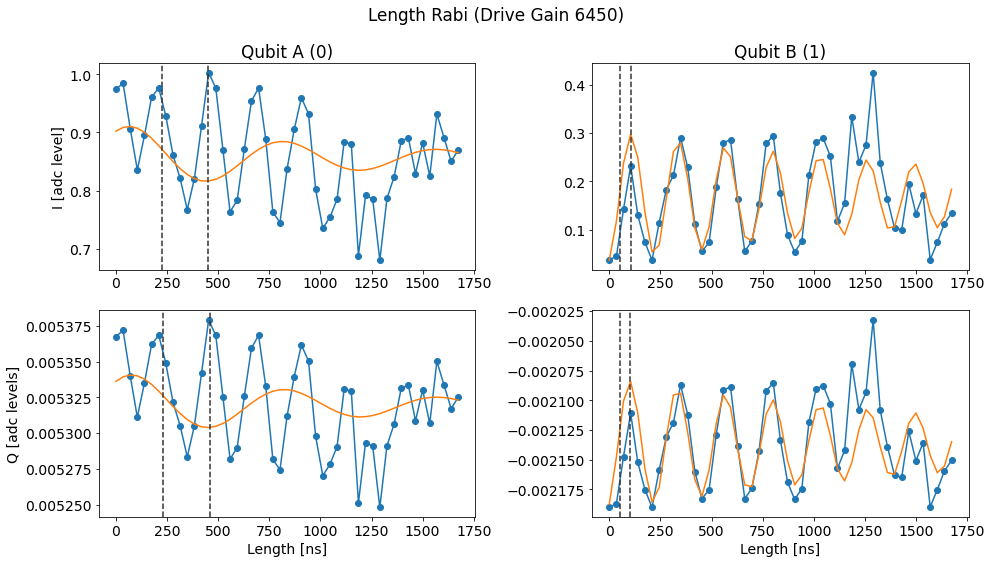

In [124]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True)
lengthrabiEgGf.display(fit=True)

In [19]:
lengthrabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_length_rabi_EgGf_qubit01.h5


# Amplitude Rabi eg-gf

In [10]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
    
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

import Pyro4.util
try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 96, 9, 58], 'f_ge': [146.3200507751049, 3464.1798421793665, 808.0847336808625, 426.8701802662663], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 254.36098271568733], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 20197, 27992, 24647], 'sigma': [0.0403, 0.02, 0.04, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 21903], 'sigma': [0.025, 0.025, 0.025, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gai

  0%|          | 0/10 [00:00<?, ?it/s]

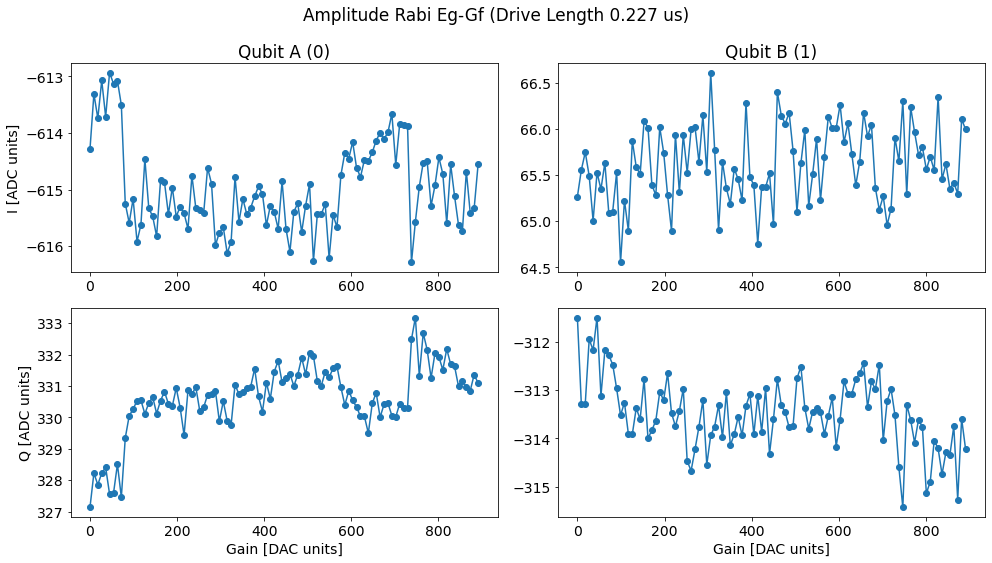

In [11]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_amp_rabi_EgGf_qubit01.h5


In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

50 23 16 11
